In [60]:
import torch
import torchvision
from torchvision.datasets import MNIST, FashionMNIST
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import math

In [65]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform) 

In [66]:
train_dataset, test_dataset

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5,), std=(0.5,))
            ),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5,), std=(0.5,))
            ))

In [67]:
class_names=train_dataset.classes

In [68]:
BATCH_SIZE=64
train_loader=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False)

print(f"Train: {len(train_loader)}, Test: {len(test_loader)}")
print(f"Per batch of Train_X Shape {next(iter(train_loader))[0].shape}")
print(f"Per batch of Train_y Shape {next(iter(train_loader))[1].shape}")

Train: 938, Test: 157
Per batch of Train_X Shape torch.Size([64, 1, 28, 28])
Per batch of Train_y Shape torch.Size([64])


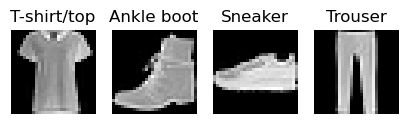

In [70]:
images, labels = next(iter(train_loader))

plt.figure(figsize=(5, 8))
for i in range(4):
    plt.subplot(1, 4, i+1)
    img = images[i].squeeze().numpy() 
    plt.imshow(img, cmap='gray', vmin=-1, vmax=1)
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

In [71]:
def make_positional_embedding(time_steps, dimension:int):
    # embedding=torch.zeros(dimension)
    
    # for i in range(dimension):
    #     k=i - i%2
    #     if i%2==0:
    #         embedding[i]=torch.sin(time_step/(10000**(k/dimension)))
    #     else:
    #         embedding[i]=torch.cos(time_step/(10000**(k/dimension)))

    # return embedding
    # idx=torch.arange(dimension)
    # k=idx -(idx%2)
    # angle=time_step/(10000**(k/dimension))
    # embedding[0::2]=torch.sin(angle[0::2])
    # embedding[1::2]=torch.cos(angle[1::2])

    # return embedding
    half = dimension // 2

    freqs_w = torch.exp(
        -torch.log(torch.tensor(10000.0)) * (torch.arange(half, dtype=torch.float32) / half)
    ).to(time_steps.device)
    args = time_steps.float().unsqueeze(1) * freqs_w.unsqueeze(0)
    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
    if dimension % 2 == 1:
        emb = torch.cat([emb, torch.zeros(time_steps.shape[0], 1, device=time_steps.device)], dim=-1)

    return emb

In [72]:
a=torch.tensor([1,2,3])
a

tensor([1, 2, 3])

In [73]:
make_positional_embedding(a,128).shape

torch.Size([3, 128])

In [74]:
torch.zeros(5)

tensor([0., 0., 0., 0., 0.])

In [75]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.SiLU(),
            nn.Linear(out_dim, out_dim)
        )
    def forward(self, x):  # x: [B, in_dim]
        return self.net(x) 

In [78]:
class UNet(nn.Module):
    def __init__(self,dimension=128, in_channels=1,out_channels=1): # can be 64 too, rule of thumb 2*base_channels(32 here)
        super().__init__()
        
        self.dimension=dimension

        self.act=nn.SiLU(inplace=True)
        # self.pool=nn.MaxPool2d(2)

        self.mlp1=MLP(in_dim=dimension,out_dim=32)
        self.enc1 = nn.Conv2d(in_channels, 32, 3, padding=1)
            
        self.pool1 = nn.MaxPool2d(2) # 14 x 14

        self.mlp2=MLP(in_dim=dimension,out_dim=64)
        self.enc2 = nn.Conv2d(32, 64, 3, padding=1)
            
        self.pool2 = nn.MaxPool2d(2) # 7 x 7

        self.mlp3=MLP(in_dim=dimension,out_dim=128)
        self.enc3 = nn.Conv2d(64, 128, 3, padding=1)
            
        self.pool3 = nn.MaxPool2d(2) # 3 x 3

        self.mlp4=MLP(in_dim=dimension,out_dim=256)
        self.enc4 = nn.Conv2d(128, 256, 3, padding=1)
            
        self.pool4 = nn.MaxPool2d(2) # 1 x 1

        self.mlp5=MLP(in_dim=dimension,out_dim=512)
        self.bottleneck = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.SiLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            # nn.SiLU(inplace=True)
        )  # 1 x 1

        self.mlp6=MLP(in_dim=dimension,out_dim=256)
        self.up4=nn.ConvTranspose2d(in_channels=512,out_channels=256, kernel_size=3, stride=3) # 3 x 3
        self.dec4 = nn.Conv2d(512, 256, 3, padding=1)
            

        self.mlp7=MLP(in_dim=dimension,out_dim=128)
        self.up3=nn.ConvTranspose2d(in_channels=256,out_channels=128, kernel_size=3, stride=2) # 7 x 7
        self.dec3 = nn.Conv2d(256, 128, 3, padding=1)
            

        self.mlp8=MLP(in_dim=dimension,out_dim=64)
        self.up2=nn.ConvTranspose2d(in_channels=128,out_channels=64, kernel_size=2, stride=2) # 14 x 14
        self.dec2 = nn.Conv2d(128, 64, 3, padding=1)
            

        self.mlp9=MLP(in_dim=dimension,out_dim=32)
        self.up1=nn.ConvTranspose2d(in_channels=64,out_channels=32, kernel_size=2, stride=2) # 28 x 28
        self.dec1 = nn.Conv2d(64, 32, 3, padding=1)

        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self,x,time_steps): 
        # x: [B, in_ch, H, W], time_steps: [B] 
        B = x.shape[0]
        uemb = make_positional_embedding(time_steps, self.dimension).to(x.device)

        # Encoder (conv -> add pos -> act)
        h1 = self.enc1(x)
        t1 = self.mlp1(uemb).view(B, 32, 1, 1)
        a1 = self.act(h1 + t1)
        p1 = self.pool1(a1)

        h2 = self.enc2(p1)
        t2 = self.mlp2(uemb).view(B, 64, 1, 1)
        a2 = self.act(h2 + t2)
        p2 = self.pool2(a2)

        h3 = self.enc3(p2)
        t3 = self.mlp3(uemb).view(B, 128, 1, 1)
        a3 = self.act(h3 + t3)
        p3 = self.pool3(a3)

        h4 = self.enc4(p3)
        t4 = self.mlp4(uemb).view(B, 256, 1, 1)
        a4 = self.act(h4 + t4)
        p4 = self.pool4(a4)

        # Bottleneck
        b = self.bottleneck(p4)
        t5 = self.mlp5(uemb).view(B, 512, 1, 1)
        a5 = self.act(b + t5)

        # Decoder: skip connect -> conv -> add pos -> activation 
        u6 = self.up4(a5)                 # (B,256,3,3)
        x6 = torch.cat([u6, a4], dim=1)   # (B,512,3,3)
        d6 = self.dec4(x6)          
        t6 = self.mlp6(uemb).view(B, 256, 1, 1)
        a6 = self.act(d6 + t6)

        u7 = self.up3(a6)
        x7 = torch.cat([u7, a3], dim=1)
        d7 = self.dec3(x7)
        t7 = self.mlp7(uemb).view(B, 128, 1, 1)
        a7 = self.act(d7 + t7)

        u8 = self.up2(a7)
        x8 = torch.cat([u8, a2], dim=1)
        d8 = self.dec2(x8)
        t8 = self.mlp8(uemb).view(B, 64, 1, 1)
        a8 = self.act(d8 + t8)

        u9 = self.up1(a8)
        x9 = torch.cat([u9, a1], dim=1)
        d9 = self.dec1(x9)
        t9 = self.mlp9(uemb).view(B, 32, 1, 1)
        a9 = self.act(d9 + t9)

        out = self.final_conv(a9)
        return out


In [79]:
model = UNet(
    dimension=128,
    in_channels=1,
    out_channels=1
)

# model = model.cuda()  # optional


# --- Create fake input batch ---
B = 4
x = torch.randn(B, 1, 28, 28)   # input
t = torch.randint(0, 1000, (B,))  # timesteps

print("Input shape:", x.shape)
print("Timestep shape:", t.shape)

# --- Run forward pass ---
out = model(x, t)

print("Output shape:", out.shape)

Input shape: torch.Size([4, 1, 28, 28])
Timestep shape: torch.Size([4])
Output shape: torch.Size([4, 1, 28, 28])


In [80]:
# T=1000
# betas=torch.linspace(1e-4,0.02,T)
# alphas=1-betas
# alpha_bars=torch.cumprod(alphas,dim=0)
# sqrt_alpha_bars=torch.sqrt(alpha_bars)
# sqrt_om_alpha_bars=torch.sqrt(1-alpha_bars) # om--one minus

In [81]:
# def q_sample(x0,t,eps):
#     # t: [B] ints in [0..T-1]
#     sqrt_alpha_t_bar=sqrt_alpha_bars[t-1].view(-1,1,1,1)
#     om_sqrt_alpha_t_bar=sqrt_om_alpha_bars[t-1].view(-1,1,1,1)
#     xt=sqrt_alpha_t_bar*x0 + om_sqrt_alpha_t_bar*eps

#     return xt

In [82]:
def cosine_beta_schedule(T, s=0.008):
    steps = T
    timesteps = torch.arange(steps + 1, dtype=torch.float64)
    alphas_cumprod = torch.cos(((timesteps / steps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = []
    for t in range(1, steps + 1):
        beta = min(1 - (alphas_cumprod[t] / alphas_cumprod[t - 1]), 0.999)
        betas.append(beta)
    return torch.tensor(betas, dtype=torch.float32)

In [83]:
class EMA:
    def __init__(self, model: nn.Module, decay=0.9999):
        self.decay = decay
        self.shadow = {}
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()
    def update(self, model):
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name].mul_(self.decay).add_(param.data, alpha=1.0 - self.decay)
    def apply_shadow(self, model):
        self.backup = {}
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.backup[name] = param.data.clone()
                param.data.copy_(self.shadow[name])
    def restore(self, model):
        for name, param in model.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.backup[name])

In [84]:
class DiffusionModel(nn.Module):
    def __init__(self,T=1000,in_channels=1,out_channels=1,beta_schedule='linear'):
        super().__init__()
        self.unet=UNet(dimension=128,in_channels=in_channels,out_channels=out_channels)

        self.T=T
        if beta_schedule == 'cosine':
            self.betas = cosine_beta_schedule(self.T)
        else:
            self.betas = torch.linspace(1e-4, 0.02, T)
        # self.betas=torch.linspace(1e-4,0.02,T)
        self.alphas=1.0-self.betas
        self.alpha_bars=torch.cumprod(self.alphas,dim=0)
        self.sqrt_alpha_bars=torch.sqrt(self.alpha_bars)
        self.sqrt_om_alpha_bars=torch.sqrt(1-self.alpha_bars) # om--one minus

    def q_sample(self,x0,t,eps):
        # x0: [B,C,H,W] ,t: [B] ints in [1..T]
        sqrt_alpha_t_bar=self.sqrt_alpha_bars[t-1].view(-1,1,1,1)
        om_sqrt_alpha_t_bar=self.sqrt_om_alpha_bars[t-1].view(-1,1,1,1)
        xt=sqrt_alpha_t_bar*x0 + om_sqrt_alpha_t_bar*eps

        return xt
    
    def p_mean_variance(self,xt,t):
        epsilon_hat=self.unet(xt,t)
        alpha_t=self.alphas[t-1].view(-1,1,1,1)
        sqrt_om_alpha_t_bar=self.sqrt_om_alpha_bars[t-1].view(-1,1,1,1)
        beta_t=self.betas[t-1].view(-1,1,1,1)

        mu_theta=(1/torch.sqrt(alpha_t))*(xt-(beta_t/sqrt_om_alpha_t_bar)*epsilon_hat)
        var = beta_t # simpler choice
        return mu_theta,var,epsilon_hat

    def p_sample(self, xt, t):
        mu, var, eps_hat = self.p_mean_variance(xt, t)
        if (t == 1).all():
            return mu
        z = torch.randn_like(xt)
        sigma = torch.sqrt(var)
        return mu + sigma * z

    def generate_output(self,shape):
        xt=torch.randn(shape)
        for t in reversed(torch.arange(1,self.T+1)):
            t_batch = torch.full((shape[0],), t, dtype=torch.long)
            xt=self.p_sample(xt,t_batch)
        return xt


    def forward(self,x0,t):
        # x0: [B,C,H,W] ,t: [B] 
        eps=torch.randn_like(x0)  # we need epsilon also of size  [B,C,H,W]
        xts=self.q_sample(x0,t,eps) # xts: [B,C,H,W]
        eps_pred = self.unet(xts, t)

        return eps_pred,eps

In [85]:
# torch.full((5,2), 0, dtype=torch.long )

In [86]:
reversed(torch.arange(1,6))

tensor([5, 4, 3, 2, 1])

In [87]:
device="cuda" if torch.cuda.is_available() else "cpu"

In [88]:
diffusion_model_1=DiffusionModel(T=200,in_channels=1,out_channels=1,beta_schedule='cosine').to(device)

In [89]:
loss_fn=nn.MSELoss()
optimizer=torch.optim.AdamW(params=diffusion_model_1.parameters(), lr=2e-4 )
EPOCHS=100

In [90]:
ema=EMA(diffusion_model_1,decay=0.995)

In [91]:
losses=[]

In [54]:
diffusion_model_1.train()
for epoch in tqdm(range(EPOCHS)):
    total_loss_of_epoch=0.0
    for batch_X,_ in train_loader:
        batch_X=batch_X.to(device)
        B=batch_X.shape[0]
        t=torch.randint(1,diffusion_model_1.T+1,(B,)).to(device)

        eps_preds,eps=diffusion_model_1(batch_X, t) 
        loss=loss_fn(eps_preds,eps)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(diffusion_model_1.parameters(), 1.0)
        optimizer.step()
        ema.update(diffusion_model_1)
        total_loss_of_epoch+=loss.item()
    
    avg_loss=total_loss_of_epoch/len(train_loader)
    print(f"Epoch : {epoch}/{EPOCHS} -- Loss : {avg_loss:.4f}")
    losses.append(avg_loss)

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 